# Vehicle Routing Optimization

**Prepared by:** William Bartel (wbartel@nd.edu, 2024) and Andrew Brooks (abrooks7@nd.edu, 2024)


## Imports

In [ ]:
# This code cell installs packages on Colab

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
    helper.install_glpk()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

--2024-10-08 05:03:33--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6493 (6.3K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   6.34K  --.-KB/s    in 0s      

2024-10-08 05:03:34 (55.7 MB/s) - ‘helper.py’ saved [6493/6493]

Installing idaes via pip...
idaes was successfully installed
idaes, version 2.6.0


Running idaes get-extensions to install Ipopt, k_aug, and more...
Checking solver versions:
Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)



[K_AUG] 0.1.0, Part of the IDAES PSE framework
Please visit https://idaes.org/ (x86_64-pc-linux-gnu), ASL(20190605)



Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimiz

In [ ]:
## IMPORT LIBRARIES
import pyomo.environ as pyo
import pandas as pd

## Problem Statement and Solution



We are given four locations (A,B,C,D) and a depot (0). A vehicle starts at the depot and can travel on a road between any two locations. We are given the cost (we can imagine this as distance or fuel) to travel between any two locaations by the given matrix, where the row is the starting location and the column is the ending location. We note this is generally a symmetric matrix, but in a general context may not be symmetric in the case of road closures or traffic.

The goal is to find a route for the vehicle starting and ending at the depot where each location is visited exactly once. This is known as the Traveling Salesman Problem, and the solution is an NP-hard problem. We seek to create a Pyomo implementation of the problem.

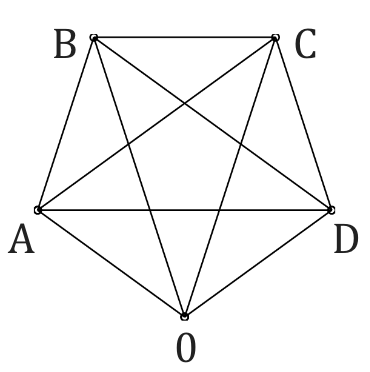

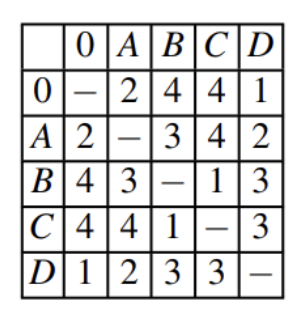



### Initial Implementation



First, we will attempt an initial solution. Let us define the problem:




---



**Sets:** $L=\{0,A,B,C,D\}$

**Parameters:** $c_{i,j} = $ distance from $i$ to $j$ for $i,j\in L$ as determined by matrix

**Variables:**
$x_{i,j} = \begin{cases}
1, \text{ if vehicle travels from $i$ to $j$},\\
0, \text{ if vehicle does not travel from $i$ to $j$}.
\end{cases}$ for $i,j\in L$

**Objective:**
$$\text{min}\sum_{i\in L}\sum_{j \in L}c_{i,j}x_{i,j}$$

**Constraints:**
$$\sum_{j\in L}x_{i,j}-\sum_{j\in L}x_{j,i}=0, \forall i\in L$$
$$\sum_{j\in L}x_{i,j}=1, \forall i\in L$$
$$x_{i,i}=0, \forall i\in L$$



---

Variables: $25$

Constraints: $15$

DOF: $25-15=10$

---

The set contains the locations, and the parameters store the cost of traveling between two locations as given by the matrix. If the vehicle travels between locations $i$ and $j$, then $x_{i,j}=1$ and the total cost increases by $c_{i,j}$. So, the objective is to minimize the sum $c_{i,j} \cdot x_{i,j}$ over all such $i$ and $j$.

The first constraint ensures the number of entries into a location equals the number of exits out of that location. The second constraint imposes that each location is exited exactly once. The final constraint gives that a vehicle cannot travel from a location to the same location.

Now, we program the problem using Pyomo.

In [ ]:
from pyomo.environ import *

# create model and define cost of each path
model = pyo.ConcreteModel()
L = ['Depot','A','B','C','D']
c = {('Depot', 'Depot'): 0, \
     ('Depot', 'A'): 2, \
     ('Depot', 'B'): 4, \
     ('Depot', 'C'): 4, \
     ('Depot', 'D'): 1, \
     ('A', 'Depot'): 2, \
     ('A', 'A'): 0, \
     ('A', 'B'): 3, \
     ('A', 'C'): 4, \
     ('A', 'D'): 2, \
     ('B', 'Depot'): 4, \
     ('B', 'A'): 3, \
     ('B', 'B'): 0, \
     ('B', 'C'): 1, \
     ('B', 'D'): 3, \
     ('C', 'Depot'): 4, \
     ('C', 'A'): 4, \
     ('C', 'B'): 1, \
     ('C', 'C'): 0, \
     ('C', 'D'): 3, \
     ('D', 'Depot'): 1, \
     ('D', 'A'): 2, \
     ('D', 'B'): 3, \
     ('D', 'C'): 3, \
     ('D', 'D'): 0, }

# decision variable x of which paths are chosen is binary
model.x = pyo.Var(L,L, within=pyo.Binary)

# set objective to the total cost of the path
@model.Objective()
def obj(m):
    return sum(c[i,j]*m.x[i,j] for i in L for j in L)

model.cons = ConstraintList()

for i in L:
    model.cons.add(expr=sum(model.x[i,j] for j in L)-sum(model.x[j,i] for j in L) == 0) # Entries = Exits
    model.cons.add(expr=sum(model.x[i,j] for j in L) == 1) # Exits = 1
    model.cons.add(expr=model.x[i,i] == 0) # No traveling from location to same location

pyo.SolverFactory('cbc').solve(model)

model.pprint()

1 Var Declarations
    x : Size=25, Index={Depot, A, B, C, D}*{Depot, A, B, C, D}
        Key                : Lower : Value : Upper : Fixed : Stale : Domain
                ('A', 'A') :     0 :   0.0 :     1 : False : False : Binary
                ('A', 'B') :     0 :   0.0 :     1 : False : False : Binary
                ('A', 'C') :     0 :   0.0 :     1 : False : False : Binary
                ('A', 'D') :     0 :   1.0 :     1 : False : False : Binary
            ('A', 'Depot') :     0 :   0.0 :     1 : False : False : Binary
                ('B', 'A') :     0 :   0.0 :     1 : False : False : Binary
                ('B', 'B') :     0 :   0.0 :     1 : False : False : Binary
                ('B', 'C') :     0 :   1.0 :     1 : False : False : Binary
                ('B', 'D') :     0 :   0.0 :     1 : False : False : Binary
            ('B', 'Depot') :     0 :   0.0 :     1 : False : False : Binary
                ('C', 'A') :     0 :   0.0 :     1 : False : False : Binary
      

We import the package networkx so that we can graph the solution as a directed graph. This gives a picture where each arrow shows the route the vehicle travels.

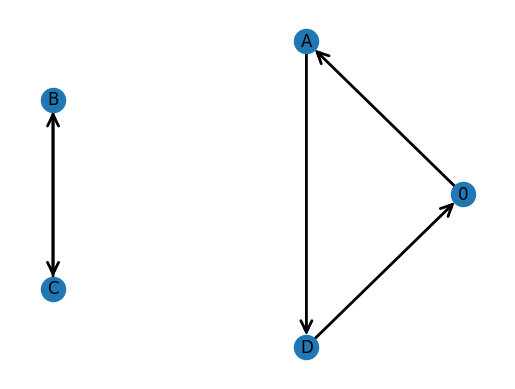

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add some nodes and edges
G.add_nodes_from(L)

edges = []

for i in L:
  for j in L:
    if value(model.x[i,j]) == 1:
      edges.append((i,j))


G.add_edges_from(edges)

pos = nx.circular_layout(G)

nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='->', arrowsize=20, width=2)
labels = {node: '0' if node == 'Depot' else node for node in G.nodes()}

# Draw the graph
nx.draw(G, pos, with_labels=True, labels=labels)
plt.show()

We notice that our initial implementation failed. Our constraints did not require for a route to be connnected, so the solution generated two separate loops. We need to add another set of constraints to address connectedness.

### MTZ Constraints and Full Solution

To address connectedness, we implement Miller-Tucker-Zemlin constraints. These are a set of constraints to ensure our solution outputs a connected graph.

First, we add a new variable $u_{i}$ for $i\in\{A,B,C,D\}$, where $u_{i}$ is equal to the order in which we visit location $i$. For example, if the route of the vehicle is $0\rightarrow A\rightarrow C\rightarrow D\rightarrow B\rightarrow 0$, then $u_{A}=1, u_{C}=2, u_{D}=3, u_{B}=4$. We omit $0$ as an index for $u_i$, since this would create confusion as to whether $u_0=0$ or $u_0=5$ with the constraints we plan to add.

First, we implement two new constraints
$$u_i\geq 1, \hspace{2mm}\forall i\in \{A,B,C,D\}$$
$$u_i\leq \text{len}(L)-1,\hspace{2mm} \forall i\in \{A,B,C,D\}$$
We use len$(L)$ in a general case, but for this specfic problem, len$(L)=5$, so we have $u_i\leq 4$. These constraints will ensure that for the $4$ locations the vehicle will visit, each integer value $1$ through $4$ will be associated to a $u_i$ for $i\in\{A,B,C,D\}$. Next, we add one more constraint
$$u_i-u_j+(\text{len}(L)-1)x_{i,j}\leq \text{len}(L)-2, \hspace{2mm}\forall i\forall j\in \{A,B,C,D\},i\neq j$$
If $x_{i,j}=0$, this statement imposes $u_i-u_j\leq\text{len}(L)-2$ which does not restrict $u_i$ or $u_j$ at all. If $x_{i,j}=1$, then $u_i-u_j\leq-1$, so $u_j>u_i$. Combined with the boundry constraints on each $u_i$, this will force $u_j=u_i+1$ if $x_{i,j}=1$.

Now, we implement these constraints and solve the model.

Full Model:

---



**Sets:**

$L=\{0,A,B,C,D\}$

**Parameters:**

$c_{i,j} = $ distance from $i$ to $j$ for $i,j\in L$ as determined by matrix

**Variables:**

$x_{i,j} = \begin{cases}
1, \text{ if vehicle travels from $i$ to $j$},\\
0, \text{ if vehicle does not travel from $i$ to $j$}.
\end{cases}$ for $i,j\in L$

$u_i = $ the order in which the car visits location $i$ for $i\in \{A,B,C,D\}$

**Objective:**
$$\text{min}\sum_{i\in L}\sum_{j \in L}c_{i,j}x_{i,j}$$

**Constraints:**
$$\sum_{j\in L}x_{i,j}-\sum_{j\in L}x_{j,i}=0, \forall i\in L$$
$$\sum_{j\in L}x_{i,j}=1, \forall i\in L$$
$$x_{i,i}=0, \forall i\in L$$
$$u_i-u_j+(\text{len}(L)-1)x_{i,j}\leq \text{len}(L)-2, \hspace{2mm}\forall i\forall j\in \{A,B,C,D\},i\neq j$$
$$u_i\geq 1, \hspace{2mm}\forall i\in \{A,B,C,D\}$$
$$u_i\leq \text{len}(L)-1,\hspace{2mm} \forall i\in \{A,B,C,D\}$$


---

Variables: $4+25=29$

Constraints: $15+12=27$

DOF: $29-27=2$

In [ ]:
# Subtour elimination (MTZ constraints)
model.u = Var({'A','B','C','D'}, within=NonNegativeReals)

# Ensure values of u are sequential
for i in L:
    for j in L:
        if i != j and i != 'Depot' and j != 'Depot':
            model.cons.add(model.u[i] - model.u[j] + (len(L) - 1) * model.x[i, j] <= len(L) - 2) #Connected cities have u values differ by 1

# Set a range for u variables
for i in L:
    if i != 'Depot':
      model.cons.add(model.u[i] >= 1)
      model.cons.add(model.u[i] <= len(L) - 1)

SolverFactory('cbc').solve(model)

model.pprint()

2 Var Declarations
    u : Size=4, Index={D, A, B, C}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          A :     0 :   1.0 :  None : False : False : NonNegativeReals
          B :     0 :   2.0 :  None : False : False : NonNegativeReals
          C :     0 :   3.0 :  None : False : False : NonNegativeReals
          D :     0 :   4.0 :  None : False : False : NonNegativeReals
    x : Size=25, Index={Depot, A, B, C, D}*{Depot, A, B, C, D}
        Key                : Lower : Value : Upper : Fixed : Stale : Domain
                ('A', 'A') :     0 :   0.0 :     1 : False : False : Binary
                ('A', 'B') :     0 :   1.0 :     1 : False : False : Binary
                ('A', 'C') :     0 :   0.0 :     1 : False : False : Binary
                ('A', 'D') :     0 :   0.0 :     1 : False : False : Binary
            ('A', 'Depot') :     0 :   0.0 :     1 : False : False : Binary
                ('B', 'A') :     0 :   0.0 :     1 : False : False : Binary
      

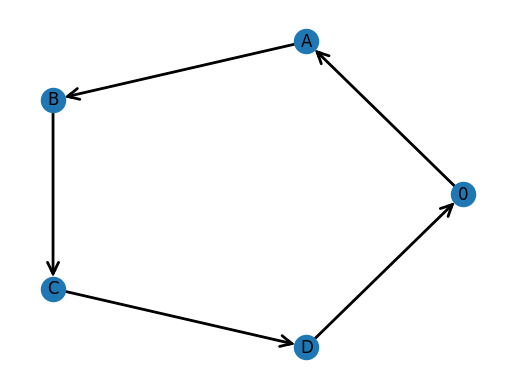

In [ ]:
# Create a directed graph
G = nx.DiGraph()

# Add some nodes and edges
G.add_nodes_from(L)

edges = []

for i in L:
  for j in L:
    if value(model.x[i,j]) == 1:
      edges.append((i,j))



G.add_edges_from(edges)
pos = nx.circular_layout(G)
labels = {node: '0' if node == 'Depot' else node for node in G.nodes()}

nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='->', arrowsize=20, width=2)

# Draw the graph
nx.draw(G, pos, with_labels=True, labels=labels)
plt.show()

We obtain a solution that is connected and minimizes the cost of travel for the vehicle.

## Integer Cuts

We utilize integer cuts to obtain the 7 best solutions to the problem. After we solve the model, we create two sets:

$$A:=\{(i,j): x_{i,j}=1\}$$
$$B:=\{(i,j): x_{i,j}=0\}$$

Then, after each time we solve the model, we add a new constraint to the model:
$$\sum_{(i,j)\in A}x_{i,j}+\sum_{(i,j)\in B}(1-x_{i,j})\leq \text{len}(L)^2-1$$
Since there are $\text{len}(L)^2$ combinations of choosing $i,j\in L$, then requiring this sum to be less than or equal to $\text{len}(L)^2-1$ ensures we cannot have a duplicate solution if we resolve the model.

Repeating this process, we obtain the $7$ best solutions (7 is chosen arbitrarily here, and we can do this to find the top $n$ solutions for any $n$).

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Objective: 10.0


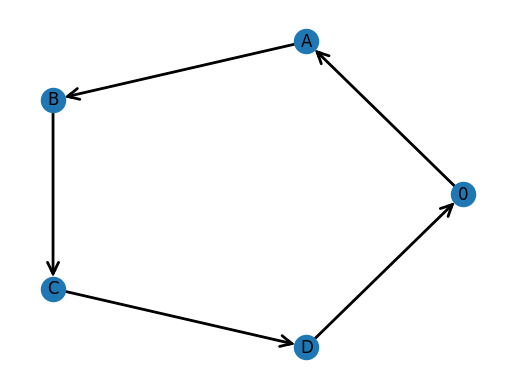


Objective: 10.0


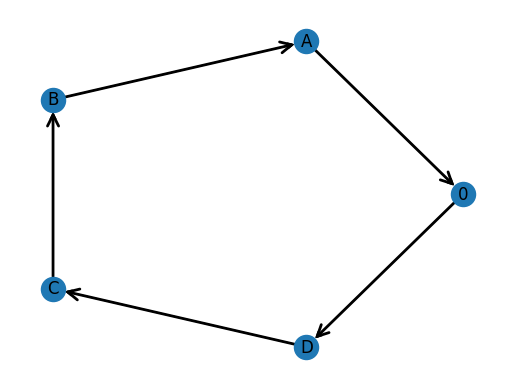


Objective: 11.0


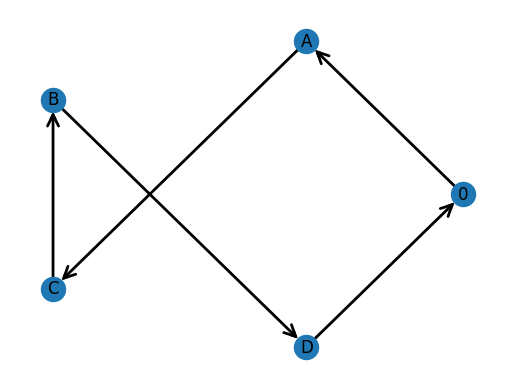


Objective: 11.0


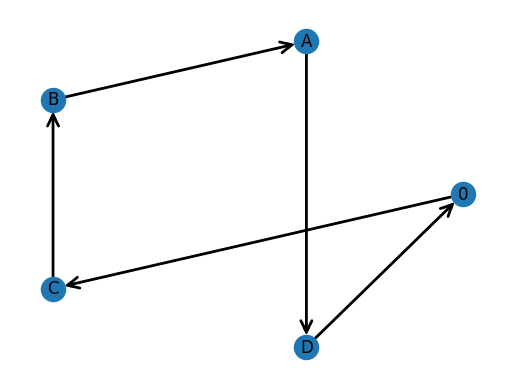


Objective: 11.0


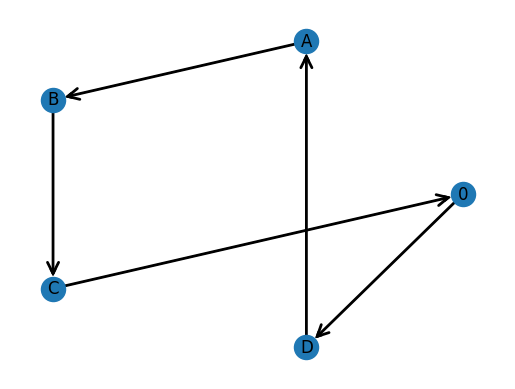


Objective: 11.0


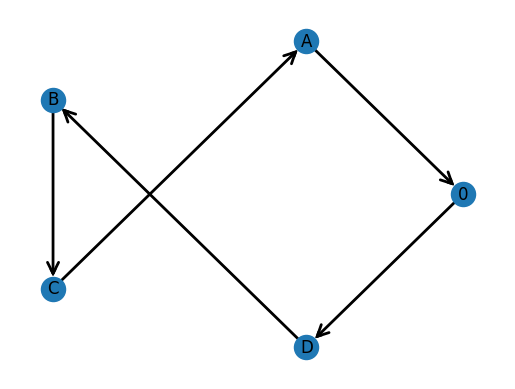


Objective: 12.0


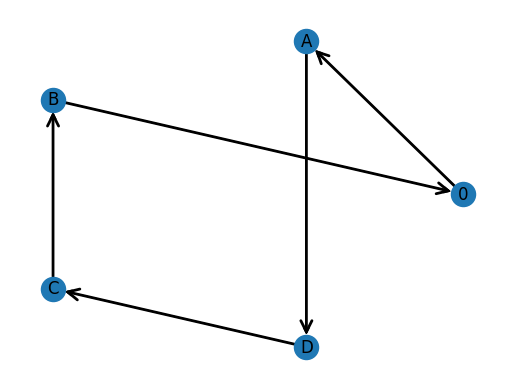

In [ ]:
# Declare the ConstraintList outside the loop
model.int_cuts = ConstraintList()

for k in range(0, 7):
    SolverFactory('cbc').solve(model)

    print(f"Objective: {pyo.value(model.obj)}")

    A = []
    B = []

    # Use tolerance to check if value is 1 or 0 (optional)
    for i in L:
        for j in L:
            if value(model.x[i, j]) == 1:
                A.append([i, j])
            else:
                B.append([i, j])

    # Create a graph using networkx
    G = nx.DiGraph()

    # Add nodes and edges based on A
    G.add_nodes_from(L)
    edges = [(i, j) for i, j in A]
    G.add_edges_from(edges)

    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='->', arrowsize=20, width=2)

    # Draw the graph
    labels = {node: '0' if node == 'Depot' else node for node in G.nodes()}

    # Visualize the graph
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, labels=labels)
    plt.show()

    # Add a new constraint to the existing ConstraintList
    model.int_cuts.add(expr=sum(model.x[i[0], i[1]] for i in A) +
                           sum(1 - model.x[i[0], i[1]] for i in B) <= pow(len(L), 2) - 1)
    print()


We obtain 2 solutions that have a cost of 10, and 4 solutions that have a cost of 11. The final solution we obtain has a cost of 12, and there are more routes with cost equal to 12 that would come next if we looked at the next best routes.

We notice that for any given route, we can traverse the route backwards to obtain another route that gives the same cost to travel. This is because our matrix of costs is symmetric.

## Extension Problem


To introduce stochastic variables into the problem, we used a formulation found online. In this related problem, which is also a combinatorial problem, the challenge is to determine the routing of a fleet of cars to a number of nodes in order to maximize the revenue while travelling from five starting points and all ending at node 20. The first stage variable is deciding how many cars to start at each of the five vehicle starting points. The stochastic variable is the demand on each path, which is not known at the time of choosing the starting spot of the vehicles. The second stage variable is the actual routing decisions once the demands of each path is known. This simulates how a company may have to choose how many vehicles to buy for each warehouse location. They can only buy a certain amount of vehicles, and they want to optimize their decision based on the possible demands of the surrounding area. The demands may change day-to-day, but they can probabilistically choose the best solution.

A visual depiction of the problem is shown below. The starting points are 1-5 and the end node is 20.

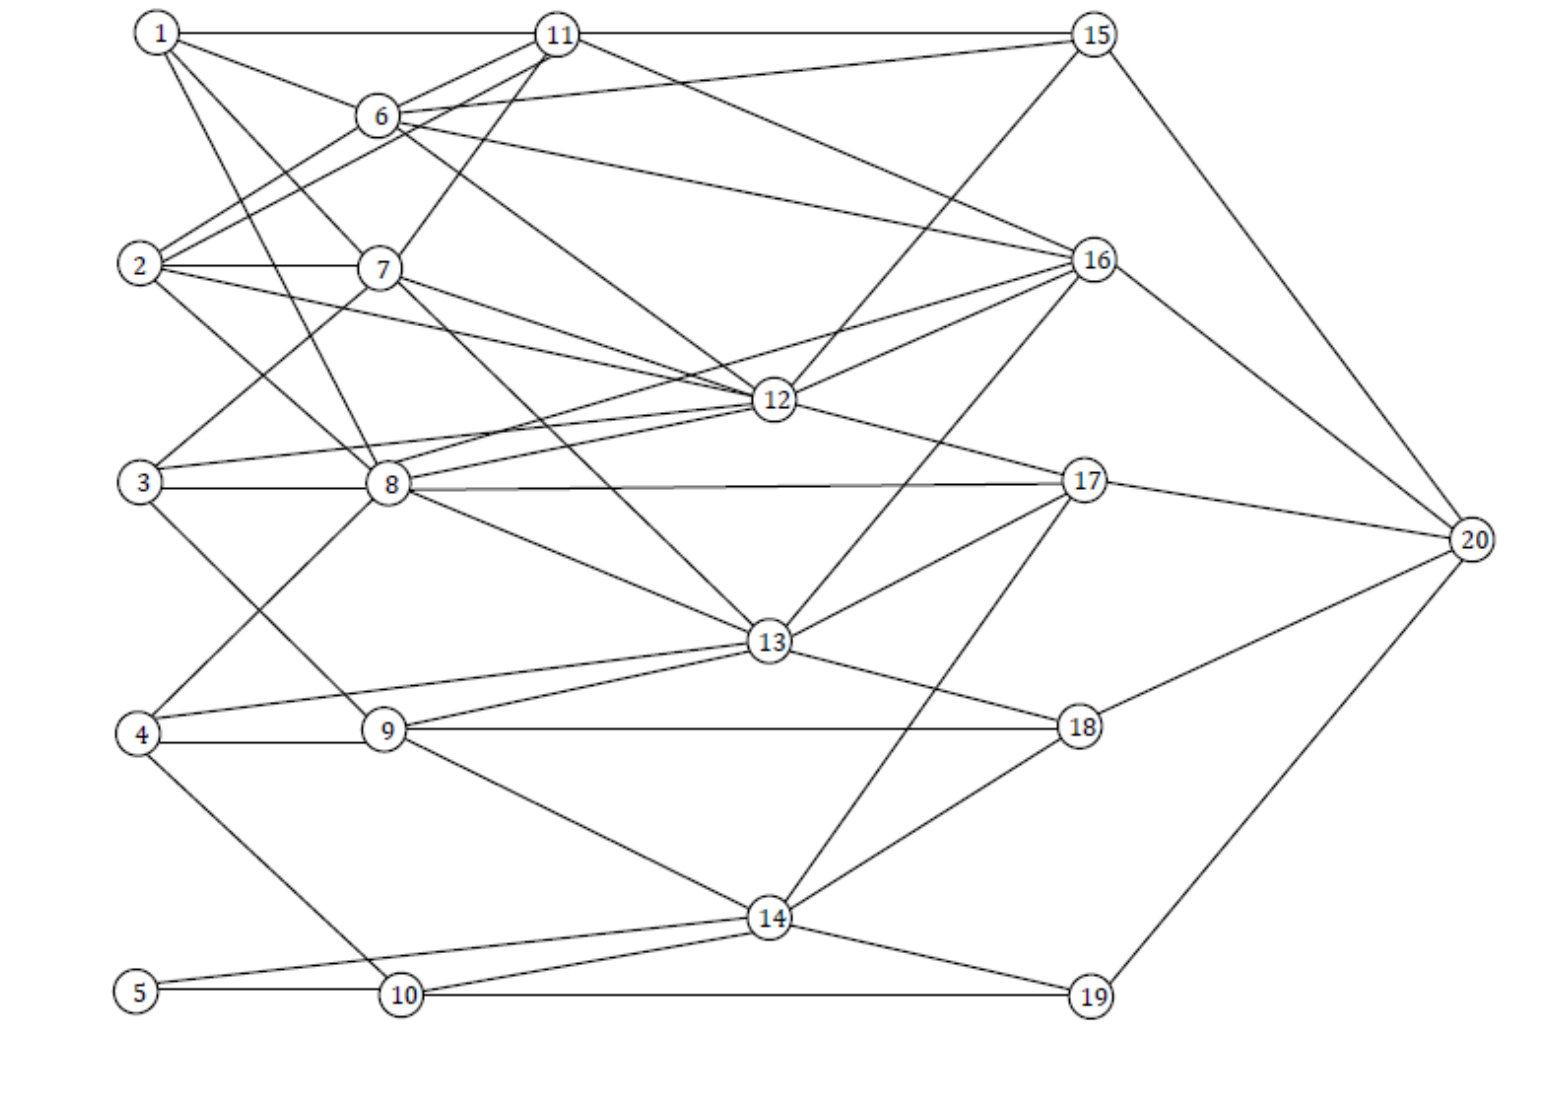

---



**Sets:**

$E =$ set of edges $(i,j)$ in network

$S =$ set of source (starting) nodes

$D =$ set of demand nodes

$\Omega =$ set of scenerios

**Parameters:**

$c_e =$ cost on edge $(i,j)=e\in E$

$r_e =$ revenue on edge $(i,j)=e\in E$

$b =$ total number of vehicles

**Random Variables:**

$d_e = $ demand on edge $(i,j)=e\in E$

**Decision Variables:**

$x_s = $ first stage number of vehicles at source node $s$

$y_e^\omega = $ second stage routing for scenerio $\omega$

$z_e^\omega = $ second stage overage for scenario $\omega$

**Objective:**
$$\text{min}\sum_{\Omega,E}\{p^\omega r_e y_e^\omega - (r_e+c_e)z_e^\omega\}$$

**Constraints:**
$$\sum_{s}x_{s}=b$$
$$\sum_{j\in J,(i,j)\in E}y_{(i,j)}^\omega=x_i,\hspace{5mm}\forall i\in S,\omega\in\Omega$$
$$\sum_{j\in J|(i,j)\in E}y_{(i,j)}^\omega=\sum_{i\in I|(j,i)\in E}y_{(j,i)}^\omega,\hspace{5mm}\forall j\in D,\omega\in\Omega$$
$$y_e^\omega-d_e^\omega\leq z_e^\omega,\hspace{5mm}\forall e\in E,\omega\in\Omega$$
$$0\leq\{x,y,z\}\leq b$$


---

Variables: $|S|+2|E||\Omega|$

Constraints: $1+|S||\Omega|+|D||\Omega|+|E||\Omega|$

DOF: $|S|-1+|\Omega|(|E|-|S|-|D|)$

---

The objective is to maximize profit. The constraints ensure (in order) that all vehicles are assigned, an enforcement of flow from the assigned vehicles at the source nodes, balance of flow at demand nodes, and excess supply at each node. All variables are nonnegative and bounded by the number of total available vehicles.

In [ ]:
#
# Imports
#
from pyomo.environ import *

#
# Model
#
model = AbstractModel()

#
# Parameters
#
# Define sets
model.I = Set() #node
model.J = Set()
model.S = Set() #source node
model.D = Set() #demand node

# Data_deterministic
model.Arc = Param(model.I, model.J) #arc available
model.Rev = Param(model.I, model.J) #arc revenue
model.Cost = Param(model.I, model.J) #arc cost
model.B = Param()

#Data_stochastic
model.ArcDemand = Param(model.I, model.J) #arc demand


# Variables
model.X = Var(model.S, bounds=(0.0, model.B), within=NonNegativeIntegers)
model.Y = Var(model.I, model.J, bounds=(0.0, model.B), within=NonNegativeIntegers)
model.Z = Var(model.I, model.J, bounds=(0.0, None))

model.FirstStageProfit = Var()
model.SecondStageProfit = Var()


# Constraints
def vehicle_num_cap_rule(model):
    return sum(model.X[s] for s in model.S) == model.B
model.VehicleNumCapRule = Constraint(rule=vehicle_num_cap_rule)

def vehicle_assigned_cap_rule(model,s):
    return sum(model.Y[s,j] for j in model.J if model.Arc[s,j]>=1) == model.X[s]
model.RequiredDemandRule = Constraint(model.S, rule=vehicle_assigned_cap_rule)

def flow_balance_rule(model,d):
    return (sum(model.Y[i,d] for i in model.I if model.Arc[i,d]>=1) - sum(model.Y[d,i] for i in model.I if model.Arc[d,i]>=1)) == 0.0
model.FlowBalanceRule = Constraint(model.D, rule=flow_balance_rule)

def overage_rule(model,i,j):
    return model.Y[i,j] - model.ArcDemand[i,j] <= model.Z[i,j]
model.OverageRule = Constraint(model.I, model.J, rule=overage_rule)

def y_rule(model,i,j):
    return (0.0, model.Y[i,j], model.Arc[i,j]*51)
model.YRule = Constraint(model.I, model.J, rule=y_rule)


# Stage-specific cost computations
def first_stage_profit_rule(model):
    return model.FirstStageProfit == 0.0
model.ComputeFirstStageProfit = Constraint(rule=first_stage_profit_rule)

def second_stage_profit_rule(model):
    return model.SecondStageProfit - sum(sum(model.Rev[i,j] * model.Y[i,j] - (model.Rev[i,j] + model.Cost[i,j])* model.Z[i,j] \
                                           for i in model.I) for j in model.J) == 0.0
model.ComputeSecondStageProfit = Constraint(rule=second_stage_profit_rule)


# Objective
def total_profit_rule(model):
    return (model.FirstStageProfit + model.SecondStageProfit)
model.Total_Profit_Objective = Objective(rule=total_profit_rule, sense=maximize)

# Solve and print
# with open('ReferenceModel.dat', 'r') as file:
#     data = file.read()
EV_model = model.create_instance('ReferenceModel.dat')
opt = SolverFactory('glpk')
results = opt.solve(EV_model)
EV = value(EV_model.Total_Profit_Objective)
print("EV = %s" % (EV))
print("Amount of vehicles at each starting point")
for i in EV_model.X:
    print("%s = %s" % (i, value(EV_model.X[i])))


EV = 17482.55
Amount of vehicles at each starting point
1 = 11.0
2 = 16.0
3 = 7.0
4 = 11.0
5 = 6.0


## Conclusion
We went beyond the material from the textbook by creating our own implementation and then learning about MTZ constraints to solve the problem. To learn more about stochastic programming, we found and implemented an extension of the problem that was more complex and made use of a stochastic variable.

## References
Birge, John R., and François Louveaux. Introduction to Stochastic Programming. 2nd ed., Springer New York, 2011, https://doi.org/10.1007/978-1-4614-0237-4.

GitHub. “.gitignore.” *Pyomo Model Libraries*, GitHub, https://github.com/Pyomo/pyomo-model-libraries/blob/main/.gitignore. Accessed October 2024.

“Miller-Tucker-Zemlin Formulation.” *AIMMS How-To*, 19 Nov. 2020, how-to.aimms.
com/Articles/332/332-Miller-Tucker-Zemlin-formulation.html. Accessed October 2024.

Stewart, William R., and Bruce L. Golden. ‘Stochastic Vehicle Routing: A Comprehensive Approach’. European Journal of Operational Research, vol. 14, no. 4, 1983, pp. 371–385, https://doi.org/10.1016/0377-2217(83)90237-0.